In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
teams_to_systems = json.load(open('team-to-submissions.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-domain', '', '-cross-domain'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240516-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

df = []
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        for d, (dname, pre, suff) in datasets.items():
            df.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **evaluation_scores[team][s][d]['_sources'][src]
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df = pd.DataFrame(df)
df.set_index(['team', 'system', 'dataset', 'category'], inplace=True)
df

roc-auc  \
team         system          dataset                     category            
cnlp-nits-pp direct-velocity alpaca-7b                   main        0.996   
                             bigscience-bloomz-7b1       main        0.988   
                             gemini-pro                  main        0.998   
                             gemini-pro-high-temperature main        0.999   
                             gpt-3.5-turbo-0125          main        0.999   
...                                                                    ...   
logistic-fsu logistic-fsu    eloquent-chatgpt35          eloquent    0.993   
                             eloquent-gptsw3             eloquent    0.879   
                             eloquent-reindeer-mistral   eloquent    1.000   
                             eloquent-reindeer-poro      eloquent    1.000   
                             eloquent-verbanex-ai        eloquent    1.000   

                                                                   brier  \
team         system          dataset                     category          
cnlp-nits-pp direct-velocity alpaca-7b                   main      0.866   
                             bigscience-bloomz-7b1       main      0.865   
                             gemini-pro                  main      0.881   
                             gemini-pro-high-temperature main      0.883   
                             gpt-3.5-turbo-0125          main      0.878   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent-chatgpt35          eloquent  0.885   
                             eloquent-gptsw3             eloquent  0.821   
                             eloquent-reindeer-mistral   eloquent  0.862   
                             eloquent-reindeer-poro      eloquent  0.881   
                             eloquent-verbanex-ai        eloquent  0.879   

                                                                     c@1  \
team         system          dataset                     category          
cnlp-nits-pp direct-velocity alpaca-7b                   main      0.986   
                             bigscience-bloomz-7b1       main      0.980   
                             gemini-pro                  main      0.996   
                             gemini-pro-high-temperature main      0.997   
                             gpt-3.5-turbo-0125          main      0.997   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent-chatgpt35          eloquent  0.958   
                             eloquent-gptsw3             eloquent  0.875   
                             eloquent-reindeer-mistral   eloquent  0.958   
                             eloquent-reindeer-poro      eloquent  1.000   
                             eloquent-verbanex-ai        eloquent  1.000   

                                                                      f1  \
team         system          dataset                     category          
cnlp-nits-pp direct-velocity alpaca-7b                   main      0.954   
                             bigscience-bloomz-7b1       main      0.934   
                             gemini-pro                  main      0.963   
                             gemini-pro-high-temperature main      0.976   
                             gpt-3.5-turbo-0125          main      0.969   
...                                                                  ...   
logistic-fsu logistic-fsu    eloquent-chatgpt35          eloquent  0.952   
                             eloquent-gptsw3             eloquent  0.889   
                             eloquent-reindeer-mistral   eloquent  0.963   
                             eloquent-reindeer-poro      eloquent  1.000   
                             eloquent-verbanex-ai        eloquent  1.000   

                                                                    f05u  \
team     

### Submissions Statistics

In [3]:
global_stats = df.reset_index()[~df.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,32
system,96
dataset,68


### System Mean Effectiveness Per Dataset

In [4]:
df_team_ds_mean = df.groupby(['category', 'dataset', 'team', 'system']).mean().sort_values(['category', 'dataset', 'mean'], ascending=[True, True, False])
df_team_ds_mean

roc-auc  \
category     dataset                                    team                           system                                                       
cross-domain alpaca-7b-cross-domain                     iimasnlp                       final-run3-gnnw2v_llmft_stylofeat-partitionB         1.000   
                                                        you-shun-you-de                charitable-mole_v3                                   1.000   
                                                                                       plain-fortress                                       1.000   
                                                        lam                            acute-wireframe                                      0.995   
                                                        iimasnlp                       final-run10-gnnllm_llmft_stylofeat-fullpartitionB    0.994   
...                                                                                                                                           ...   
unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half baseline-binoculars-mistral    baseline-binoculars-mistral                          0.046   
                                                        foshan-university-of-guangdong adjacent-rate                                        0.000   
                                                        j1j                            soft-electrolysis                                    0.000   
                                                                                       tangy-frequency                                      0.000   
                                                                                       forward-oil                                          0.000   

                                                                                                                                          brier  \
category     dataset                                    team                           system                                                     
cross-domain alpaca-7b-cross-domain                     iimasnlp                       final-run3-gnnw2v_llmft_stylofeat-partitionB       1.000   
                                                        you-shun-you-de                charitable-mole_v3                                 0.995   
                                                                                       plain-fortress                                     0.995   
                                                        lam                            acute-wireframe                                    0.995   
                                                        iimasnlp                       final-run10-gnnllm_llmft_stylofeat-fullpartitionB  0.987   
...                                                                                                                                         ...   
unicode-half meta-llama-llama-2-7b-chat-hf-unicode-half baseline-binoculars-mistral    baseline-binoculars-mistral                        0.195   
                                                        foshan-university-of-guangdong adjacent-rate                                      0.422   
                                                        j1j                            soft-electrolysis                                  0.237   
                                                                                       tangy-frequency                                    0.227   
                                                                                       forward-oil                                        0.147   

                                                                                                                                            c@1  \
category     dataset                                    team                           system                                                

### System Mean Performance Per Dataset Category

In [5]:
df_team_ds_cat_mean = df.groupby(['category', 'team', 'system']).mean().sort_values(['category', 'mean'], ascending=[True, False])
df_team_ds_cat_mean

roc-auc  \
category     team                           system                                                        
cross-domain you-shun-you-de                charitable-mole_v3                                 0.989267   
                                            plain-fortress                                     0.989267   
             iimasnlp                       final-run10-gnnllm_llmft_stylofeat-fullpartitionB  0.989600   
             lam                            blistering-moss                                    0.986800   
             iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA   0.988733   
...                                                                                                 ...   
unicode-half baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral                     0.000000   
             foshan-university-of-guangdong adjacent-rate                                      0.000000   
             j1j                            soft-electrolysis                                  0.000000   
                                            tangy-frequency                                    0.000000   
                                            forward-oil                                        0.000000   

                                                                                                  brier  \
category     team                           system                                                        
cross-domain you-shun-you-de                charitable-mole_v3                                 0.988533   
                                            plain-fortress                                     0.988533   
             iimasnlp                       final-run10-gnnllm_llmft_stylofeat-fullpartitionB  0.985733   
             lam                            blistering-moss                                    0.986667   
             iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA   0.980133   
...                                                                                                 ...   
unicode-half baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral                     0.475500   
             foshan-university-of-guangdong adjacent-rate                                      0.430833   
             j1j                            soft-electrolysis                                  0.206500   
                                            tangy-frequency                                    0.199500   
                                            forward-oil                                        0.130167   

                                                                                                    c@1  \
category     team                           system                                                        
cross-domain you-shun-you-de                charitable-mole_v3                                 0.989133   
                                            plain-fortress                                     0.989133   
             iimasnlp                       final-run10-gnnllm_llmft_stylofeat-fullpartitionB  0.989133   
             lam                            blistering-moss                                    0.986667   
             iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA   0.982133   
...                                                                                                 ...   
unicode-half baseline-fastdetectgpt-mistral baseline-fastdetectgpt-mistral                     0.000000   
             foshan-university-of-guangdong adjacent-rate                                      0.000000   
             j1j                            soft-electrolysis                                  0.000000   
                                            tangy-frequency                                    0.000000   
                            

### System Effectiveness Spread

In [6]:
df_system_std = df_team_ds_mean.groupby(['team', 'system']).std().sort_values('mean')
df_system_std

roc-auc     brier  \
team                           system                                  
foshan-university-of-guangdong independent-net    0.007455  0.002196   
lam                            several-fleet      0.030059  0.034500   
gra                            ash-causeway       0.000000  0.000000   
turtlewu                       no_change_test     0.059197  0.041335   
no-999                         method1            0.065018  0.010891   
...                                                    ...       ...   
j1j                            soft-electrolysis  0.362793  0.240720   
                               tangy-frequency    0.363776  0.242986   
karami-kheiri                  bare-broker        0.243745  0.093535   
yomiya                         coherent-latitude  0.239665  0.111445   
j1j                            forward-oil        0.364881  0.264769   

                                                       c@1        f1  \
team                           system                                  
foshan-university-of-guangdong independent-net    0.011524  0.022649   
lam                            several-fleet      0.062277  0.058810   
gra                            ash-causeway       0.057560  0.053370   
turtlewu                       no_change_test     0.052484  0.104773   
no-999                         method1            0.051889  0.127531   
...                                                    ...       ...   
j1j                            soft-electrolysis  0.341707  0.343452   
                               tangy-frequency    0.341754  0.344072   
karami-kheiri                  bare-broker        0.448723  0.429610   
yomiya                         coherent-latitude  0.452390  0.425462   
j1j                            forward-oil        0.347135  0.348029   

                                                      f05u      mean  
team                           system                                 
foshan-university-of-guangdong independent-net    0.025107  0.013131  
lam                            several-fleet      0.062801  0.032464  
gra                            ash-causeway       0.057524  0.033723  
turtlewu                       no_change_test     0.075060  0.048090  
no-999                         method1            0.090756  0.056525  
...                                                    ...       ...  
j1j                            soft-electrolysis  0.346063  0.325938  
                               tangy-frequency    0.345819  0.326825  
karami-kheiri                  bare-broker        0.432570  0.328622  
yomiya                         coherent-latitude  0.432911  0.331150  
j1j                            forward-oil        0.349578  0.333641  

[103 rows x 6 columns]

### System Mean Effectiveness

In [7]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
df_system_mean.to_csv('../data/eval-figures/system-effectiveness.csv')
df_system_mean

roc-auc  \
team                           system                                                       
you-shun-you-de                plain-fortress                                    0.960044   
                               charitable-mole_v3                                0.960044   
marsan                         staff-trunk                                       0.978660   
g-fosunlpteam                  gritty-producer                                   0.952882   
iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.942286   
...                                                                                   ...   
turtlewu                       cnn_fanle                                         0.351765   
foshan-university-of-guangdong pizzicato-radian                                  0.482456   
turtlewu                       transform_fanle                                   0.288279   
lam                            several-fleet                                     0.492837   
foshan-university-of-guangdong independent-net                                   0.502721   

                                                                                    brier  \
team                           system                                                       
you-shun-you-de                plain-fortress                                    0.955574   
                               charitable-mole_v3                                0.955574   
marsan                         staff-trunk                                       0.946509   
g-fosunlpteam                  gritty-producer                                   0.917118   
iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.938816   
...                                                                                   ...   
turtlewu                       cnn_fanle                                         0.575250   
foshan-university-of-guangdong pizzicato-radian                                  0.723647   
turtlewu                       transform_fanle                                   0.386912   
lam                            several-fleet                                     0.733980   
foshan-university-of-guangdong independent-net                                   0.750338   

                                                                                      c@1  \
team                           system                                                       
you-shun-you-de                plain-fortress                                    0.957794   
                               charitable-mole_v3                                0.957794   
marsan                         staff-trunk                                       0.940736   
g-fosunlpteam                  gritty-producer                                   0.947206   
iimasnlp                       final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.939306   
...                                                                                   ...   
turtlewu                       cnn_fanle                                         0.373441   
foshan-university-of-guangdong pizzicato-radian                                  0.225059   
turtlewu                       transform_fanle                                   0.367397   
lam                            several-fleet                                     0.035122   
foshan-university-of-guangdong independent-net                                   0.006279   

                                                                                       f1  \
team                           system                                                       
you-shun-you-de                plain-fortress                                    0.942382   
                               charitable-mole_v3                                0.942382   
marsan                         staff-trunk                                      

### System Mean Effectiveness (Stability-adjusted)

In [8]:
df_system_mean_adjusted = (df_system_mean - df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')
df_system_mean_adjusted

roc-auc  \
team                           system                                                       
you-shun-you-de                charitable-mole_v3                                0.898372   
                               plain-fortress                                    0.898372   
marsan                         staff-trunk                                       0.927499   
iimasnlp                       final-run6-gnnllm_llmft_stylofeat-fullpartitionA  0.860096   
                               final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.861191   
...                                                                                   ...   
turtlewu                       change_test                                       0.154079   
foshan-university-of-guangdong independent-net                                   0.495266   
lam                            several-fleet                                     0.462778   
turtlewu                       cnn_fanle                                         0.097343   
                               transform_fanle                                   0.000000   

                                                                                    brier  \
team                           system                                                       
you-shun-you-de                charitable-mole_v3                                0.892726   
                               plain-fortress                                    0.892726   
marsan                         staff-trunk                                       0.880619   
iimasnlp                       final-run6-gnnllm_llmft_stylofeat-fullpartitionA  0.860651   
                               final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.862068   
...                                                                                   ...   
turtlewu                       change_test                                       0.473406   
foshan-university-of-guangdong independent-net                                   0.748142   
lam                            several-fleet                                     0.699479   
turtlewu                       cnn_fanle                                         0.423026   
                               transform_fanle                                   0.109986   

                                                                                      c@1  \
team                           system                                                       
you-shun-you-de                charitable-mole_v3                                0.894590   
                               plain-fortress                                    0.894590   
marsan                         staff-trunk                                       0.847693   
iimasnlp                       final-run6-gnnllm_llmft_stylofeat-fullpartitionA  0.860748   
                               final-run7-gnnllm_llmft_stylofeat-fullpartitionA  0.858962   
...                                                                                   ...   
turtlewu                       change_test                                       0.208100   
foshan-university-of-guangdong independent-net                                   0.000000   
lam                            several-fleet                                     0.000000   
turtlewu                       cnn_fanle                                         0.123598   
                               transform_fanle                                   0.082303   

                                                                                       f1  \
team                           system                                                       
you-shun-you-de                charitable-mole_v3                                0.863807   
                               plain-fortress                                    0.863807   
marsan                         staff-trunk                                      

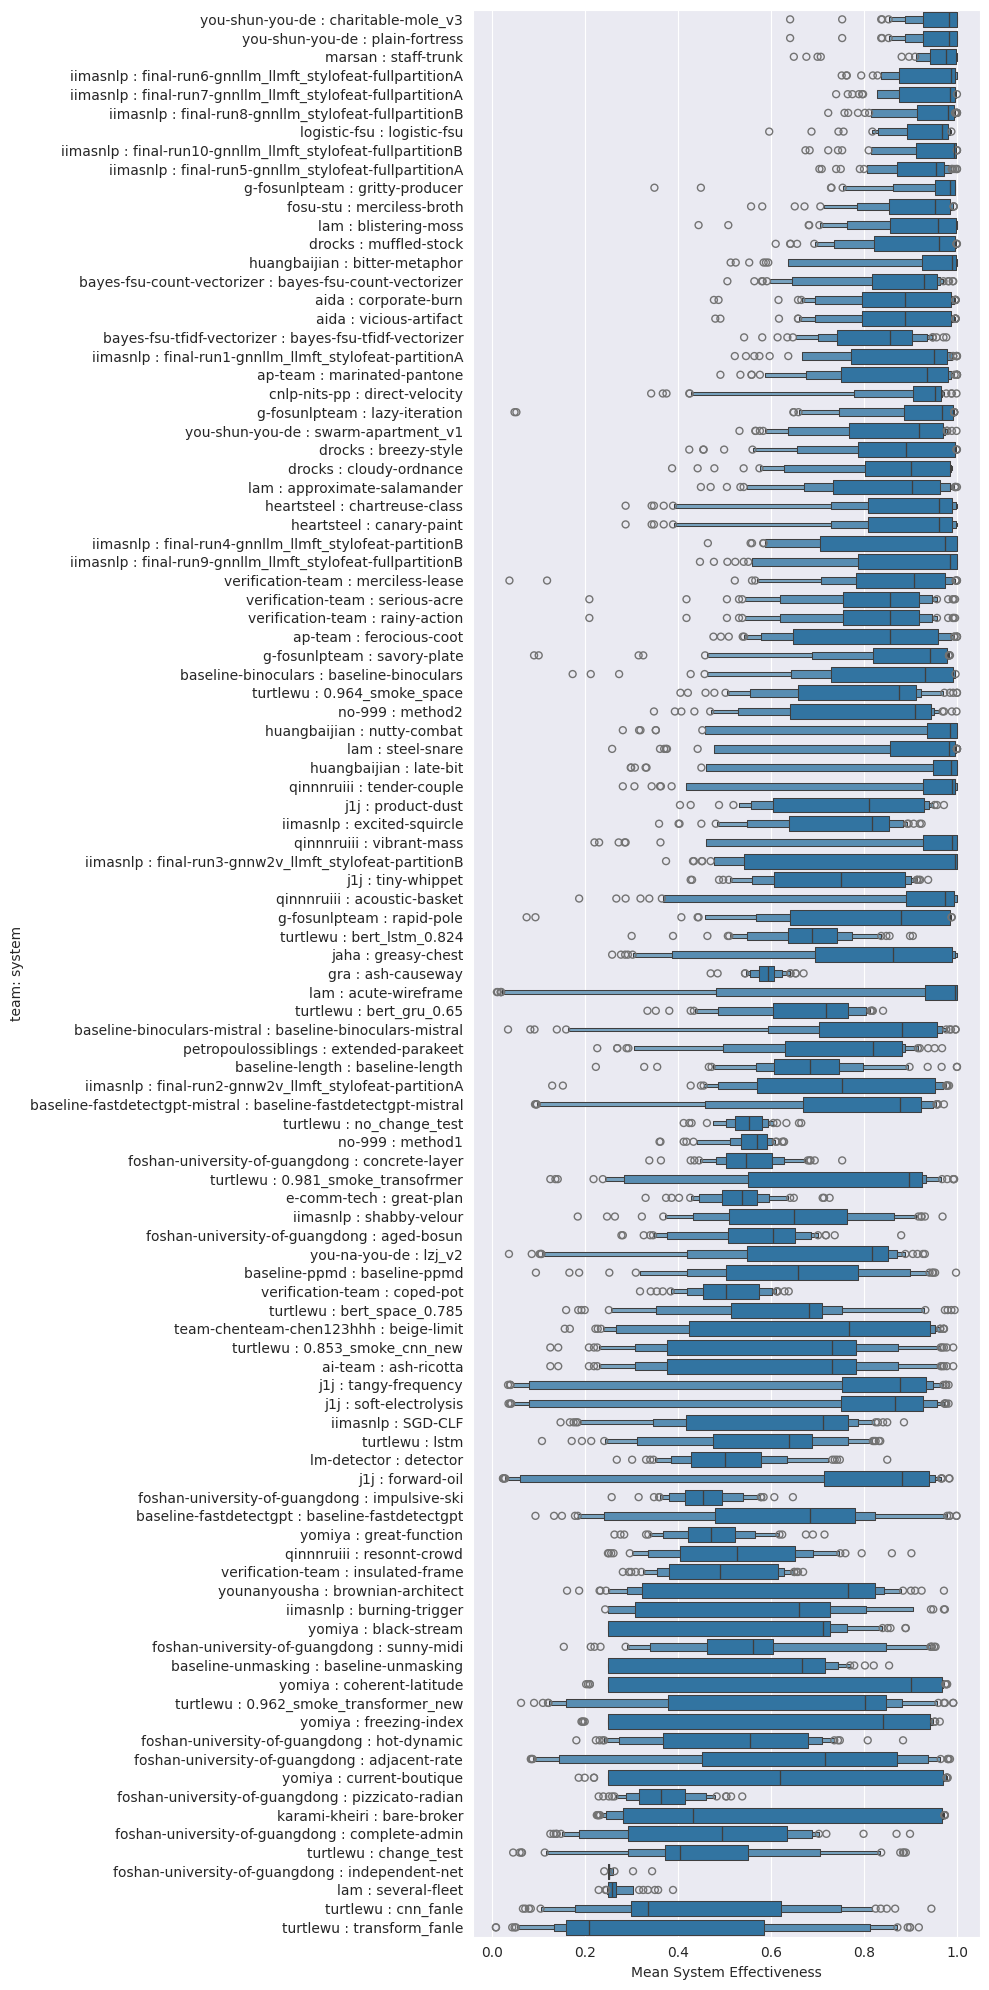

In [9]:
df_team_cat = df.reset_index()
df_team_cat['system'] = df_team_cat['team'] + ' : ' + df_team_cat['system']
df_team_cat.set_index(['team', 'system', 'dataset', 'category'], inplace=True)

sort_order = df_system_mean_adjusted['mean'].groupby(['team', 'system']).mean().sort_values(ascending=False).reset_index()
sort_order = sort_order['team'] + ' : ' + sort_order['system']

plt.figure(figsize=(10, 20))
sns.boxenplot(data=df_team_cat, y='system', x='mean', order=sort_order).set(xlabel='Mean System Effectiveness', ylabel='team: system')
plt.tight_layout()
plt.savefig('../data/eval-figures/system-effectiveness.pdf')
plt.show()

### Team Mean Effectiveness

In [10]:
df_team_mean_adjusted = df_system_mean_adjusted.groupby('team').mean().sort_values('mean', ascending=False)
df_team_mean_adjusted.to_csv('../data/eval-figures/team-effectiveness-adjusted.csv')
df_team_mean_adjusted

,roc-auc,brier,c@1,f1,f05u,mean
team,,,,,,
marsan,0.927499,0.880619,0.847693,0.793905,0.876460,0.866713
logistic-fsu,0.906418,0.822013,0.842291,0.829113,0.820399,0.847030
you-shun-you-de,0.853823,0.843061,0.839398,0.772790,0.824630,0.828859
fosu-stu,0.842205,0.843843,0.800804,0.744504,0.766807,0.802314
bayes-fsu-count-vectorizer,0.779639,0.784492,0.722154,0.705686,0.680249,0.737827
aida,0.763748,0.775285,0.716489,0.705655,0.697729,0.735816
drocks,0.753863,0.760154,0.709024,0.702079,0.698686,0.727339
bayes-fsu-tfidf-vectorizer,0.893861,0.788563,0.600023,0.704387,0.604441,0.724742
cnlp-nits-pp,0.756794,0.735171,0.704678,0.694903,0.697635,0.719837


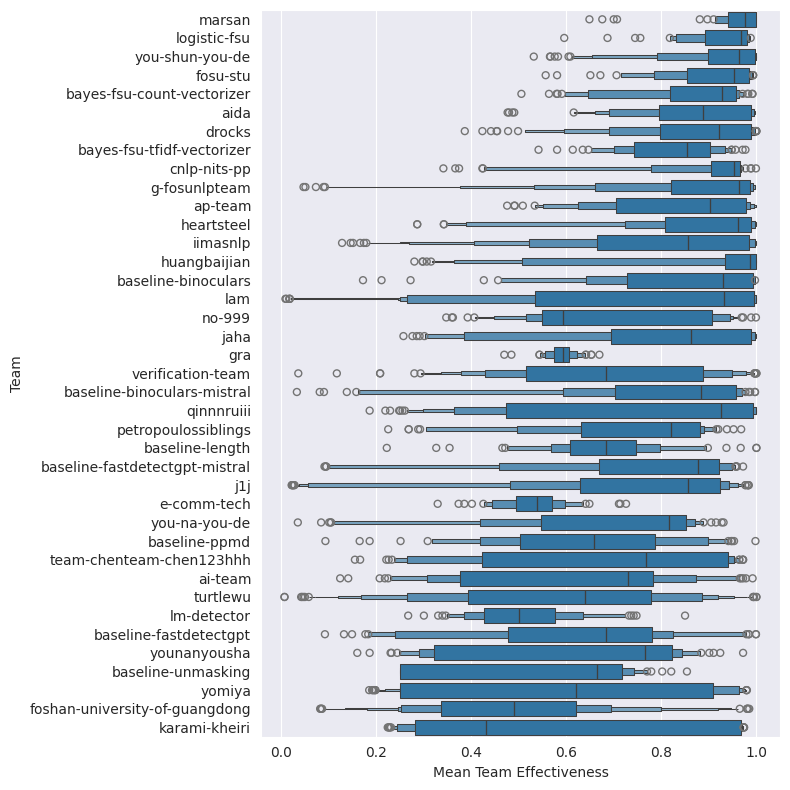

In [11]:
plt.figure(figsize=(8, 8))
sns.boxenplot(data=df, y='team', x='mean', order=df_team_mean_adjusted.index).set(xlabel='Mean Team Effectiveness', ylabel='Team')
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [12]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
gpt-4-turbo-preview-german-short,0.508384,0.386326,0.573221,0.614395,0.592291,0.534895
text-bison-002-german-short,0.509047,0.376884,0.574558,0.604767,0.599477,0.532965
gemini-pro-high-temperature-unicode-half,0.435854,0.347990,0.478350,0.510350,0.524485,0.459379
vicgalle-gpt2-open-instruct-v1-short,0.365430,0.280640,0.428047,0.560837,0.582977,0.443593
alpaca-7b-short,0.354837,0.279070,0.437814,0.553756,0.589930,0.443081
...,...,...,...,...,...,...
meta-llama-llama-2-70b-chat-hf-cross-domain,0.149554,0.124465,0.185059,0.192614,0.186337,0.167624
text-bison-002,0.151078,0.123311,0.183417,0.194728,0.180961,0.166738
qwen-qwen1.5-72b-chat-8bit,0.147990,0.120845,0.180913,0.193835,0.183893,0.165466


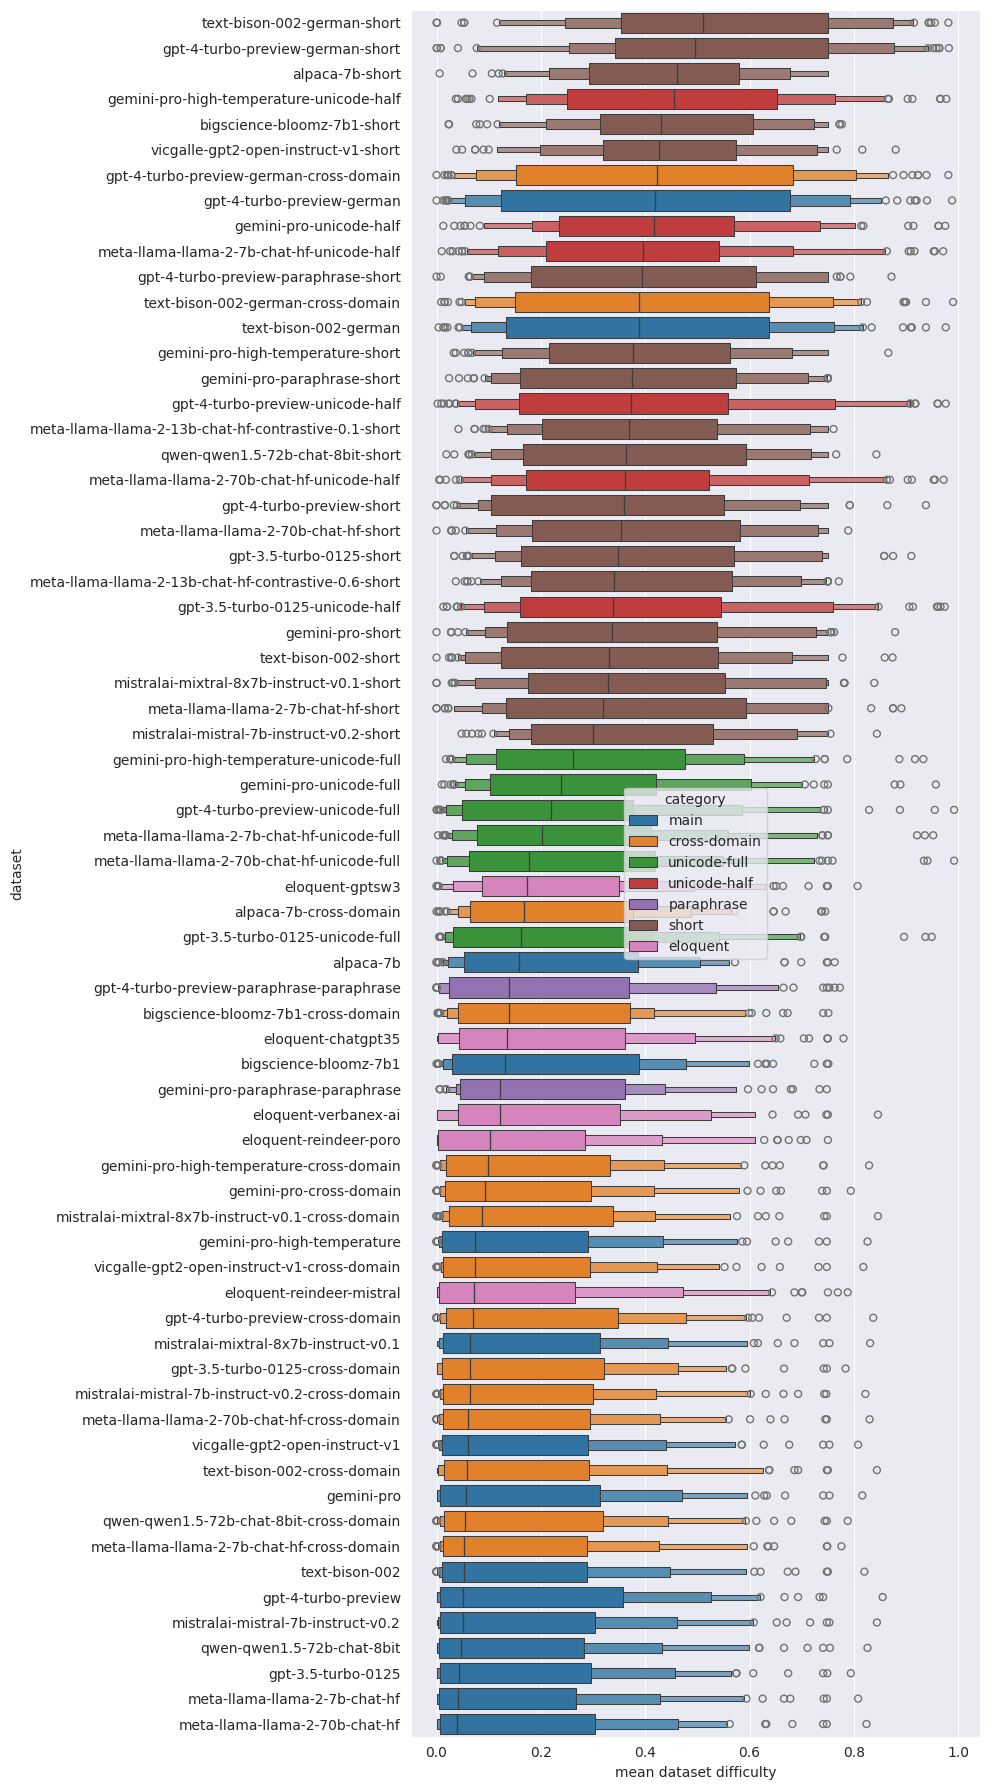

In [13]:
sort_order = df.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(10, 18))
sns.boxenplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(xlabel='mean dataset difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

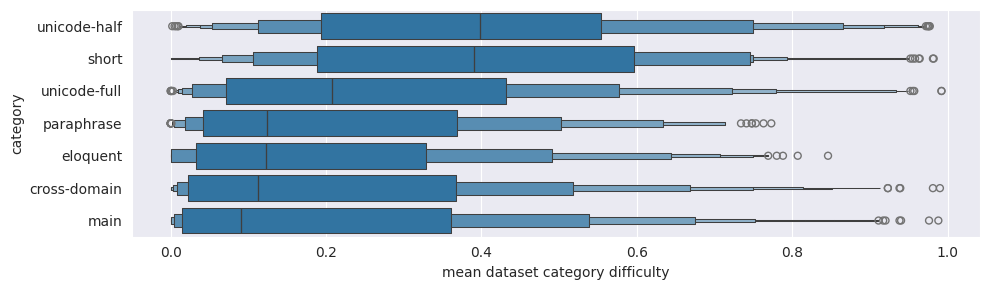

In [14]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(10, 3))
sns.boxenplot(data=(1 - df), y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

In [15]:
top_idx = df_team_mean_adjusted.iloc[:20].index
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 3))
sns.boxenplot(data=df_top, y='category', x='mean', order=sort_order).set(xlabel='mean dataset category difficulty')
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

IndexError: Too many levels: Index has only 1 level, not 2

### ELOQUENT Breaker Effectiveness

In [ ]:
df_eloquent_ds = 1 - df.loc[:, :, :, 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

In [ ]:
sort_order = df_eloquent_ds.groupby('system').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(10, 20))
sns.boxplot(data=df_eloquent_ds, y='system', x='mean', order=sort_order).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [ ]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

In [ ]:
plt.figure()
sns.boxenplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(xlabel='mean detection error')
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()